In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# List all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ideaaaafinal/saved_images/labels_resampled.csv
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_6663.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_6118.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_156.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_4558.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_269.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_5179.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_320.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_4616.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_5764.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_5889.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_4907.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_4380.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_496.jpg
/kaggle/input/ideaaaafinal/saved_images/0/resampled_image_5908.jpg
/kagg

In [2]:
!pip install timm

In [3]:
from fastai.vision.all import *
import timm

['0', '1']
2


epoch,train_loss,valid_loss,accuracy,time
0,0.982137,0.632181,0.695685,01:27


epoch,train_loss,valid_loss,accuracy,time
0,0.544251,0.462997,0.796875,01:28
1,0.425961,0.317292,0.866071,01:27
2,0.304013,0.244425,0.902530,01:29
3,0.215375,0.188785,0.924851,01:29
4,0.166187,0.174127,0.933036,01:29


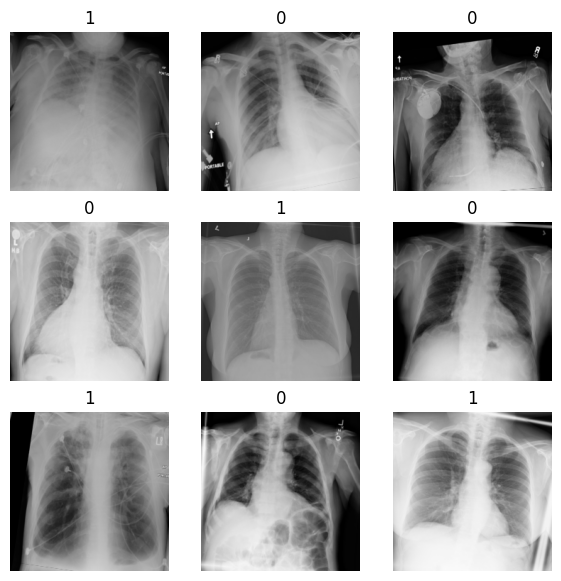

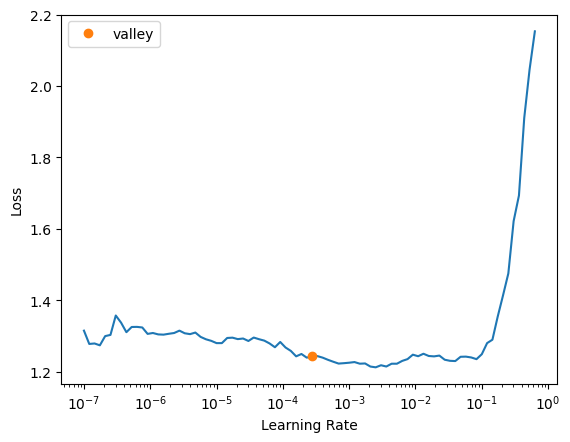

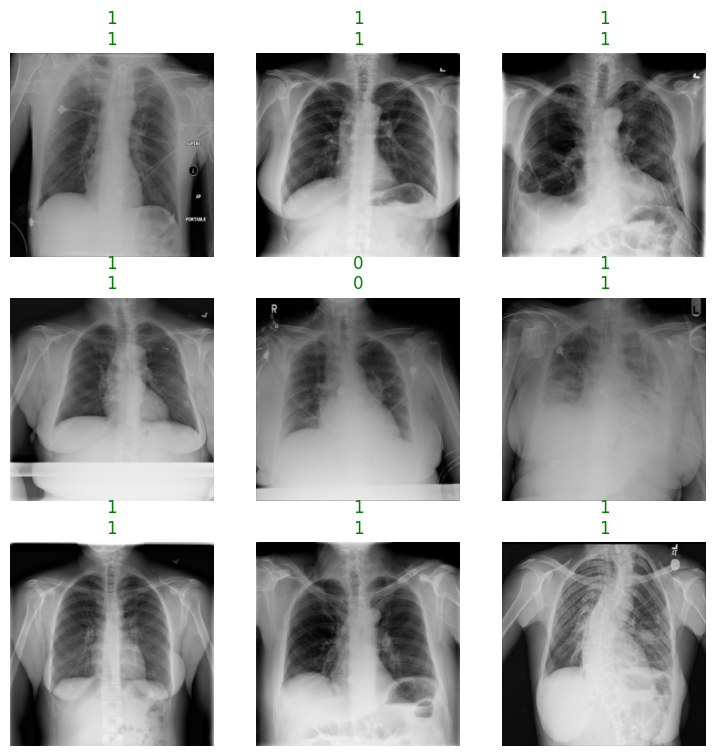

In [43]:
from fastai.vision.all import *
from fastai.metrics import error_rate
from torchvision.models import resnet50

# Path to your dataset (replace with your path)
path = Path('/kaggle/input/ideaaaafinal')

# Create a DataBlock to manage how the data is loaded
# Assuming the folder names represent the labels (classes)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Images as input, categories as target
    get_items=get_image_files,           # How to get the list of image files
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 80% train, 20% validation
    get_y=parent_label,                  # Get label from parent folder name
    item_tfms=Resize(460),               # Resize images to a consistent size before augmentations
    batch_tfms=aug_transforms(size=224, max_warp=0.1)  # Data augmentation (resize to 224 for ResNet50)
)

# Create the DataLoader
dls = dblock.dataloaders(path, bs=64)  # Adjust batch size bs according to your GPU memory
print(dls.vocab)  # This will show the unique classes/labels
print(len(dls.vocab))  # Number of unique classes

# Visualize a batch of data
dls.show_batch(max_n=9, figsize=(7,7))

# Create the learner with ResNet50 architecture and accuracy metric
learn = vision_learner(dls, resnet50, metrics=accuracy)

# Find the best learning rate
learn.lr_find()

# Train the model using fine-tuning (Fit One Cycle)
learn.fine_tune(5, base_lr=3e-3)  # Adjust epochs and learning rate as needed

# Evaluate the model on the validation set
learn.show_results()




os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


  0%|          | 0/1000 [00:00<?, ?it/s]

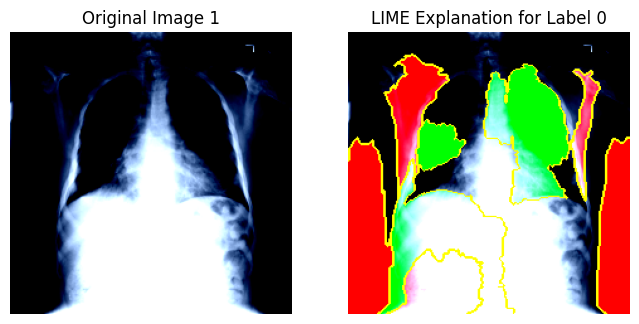

  0%|          | 0/1000 [00:00<?, ?it/s]

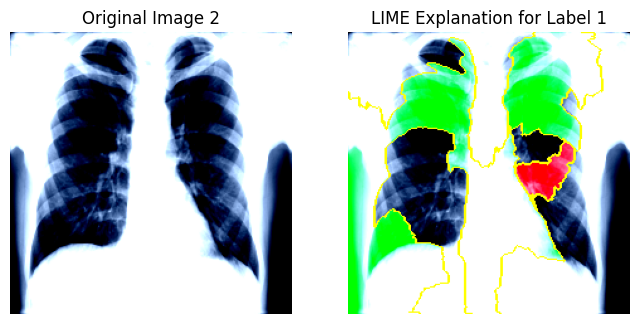

  0%|          | 0/1000 [00:00<?, ?it/s]

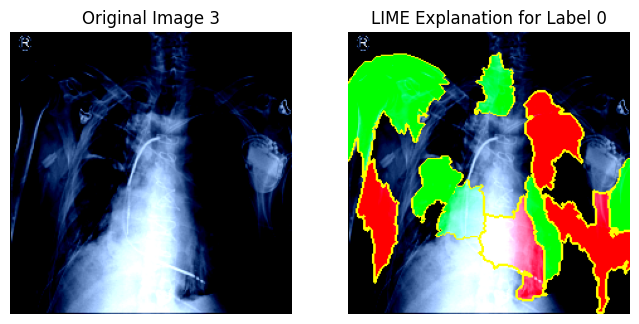

  0%|          | 0/1000 [00:00<?, ?it/s]

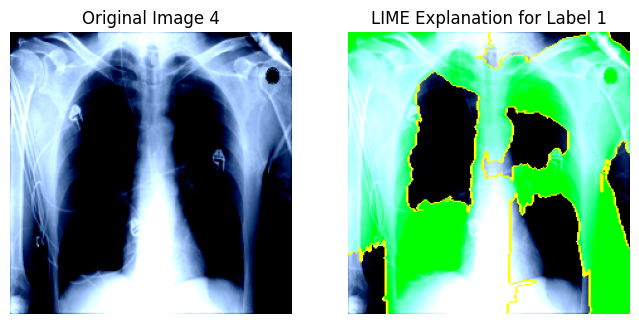

  0%|          | 0/1000 [00:00<?, ?it/s]

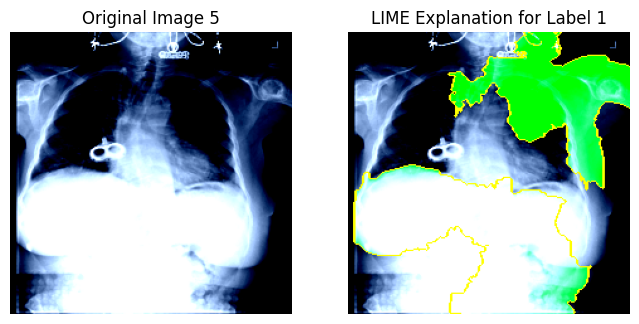

In [46]:
import torch
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load your trained model
# Ensure the model is on the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learn.model = learn.model.to(device)

# Define a function to get predictions from the model
def predict_fn(images):
    images = torch.Tensor(images).permute(0, 3, 1, 2)  # Convert to [B, C, H, W]
    images = images.to(device)  # Move images to the same device as the model
    preds = learn.model(images)  # Get the model's predictions
    return preds.softmax(dim=-1).cpu().detach().numpy()  # Move predictions back to CPU

# Choose a batch of images to explain
# Modify this part according to how you're loading/choosing images from your dataset
batch_size = 5  # Specify the number of images you want to explain
images_to_explain = next(iter(learn.dls.valid))[0][:batch_size]  # Get a batch of images from validation set
images_to_explain_np = images_to_explain.permute(0, 2, 3, 1).cpu().numpy()  # Convert to numpy for LIME

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Iterate over the batch of images and explain each one
for i, image_np in enumerate(images_to_explain_np):
    # Explain the image with LIME
    explanation = explainer.explain_instance(image_np, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

    # Get the explanation for the top label
    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=10, hide_rest=False)

    # Visualize the result
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation for Label {top_label}')
    plt.axis('off')

    plt.show()
